1) INSTALL AND IMPORTS

In [1]:
!pip install -q tensorflow matplotlib scikit-learn pillow

import os, zipfile, shutil, glob, random
import numpy as np
import matplotlib.pyplot as plt
import itertools
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30        # you can raise to 25–30 if needed
FINETUNE_EPOCHS = 10 # extra epochs after unfreezing


2) UPLOAD AND EXTRACT ZIP


In [2]:
from google.colab import files
uploaded = files.upload()  # Upload your zip that contains "dataset/" (with class folders inside)

zip_path = list(uploaded.keys())[0]
os.makedirs("data", exist_ok=True)
with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall("data")

print("Extracted to ./data")


Saving Animal_Classification.zip to Animal_Classification.zip
Extracted to ./data


3) Find the real dataset root and flatten one extra wrapper if present

In [3]:
def find_dataset_root(base="data"):
    # Prefer a folder literally named "dataset"
    for root, dirs, _ in os.walk(base):
        for d in dirs:
            if d.lower() == "dataset":
                return os.path.join(root, d)
    # Fallback: if there is only one directory under data and it contains class folders
    subdirs = [d for d in os.listdir(base) if os.path.isdir(os.path.join(base, d))]
    if len(subdirs) == 1:
        return os.path.join(base, subdirs[0])
    return base  # last resort

dataset_dir = find_dataset_root("data")

# If there's a single inner folder (e.g., "Animal Classification") containing the class folders, move them up
inner_dirs = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
if len(inner_dirs) == 1 and len([x for x in os.listdir(os.path.join(dataset_dir, inner_dirs[0]))
                                 if os.path.isdir(os.path.join(dataset_dir, inner_dirs[0], x))]) >= 2:
    inner = os.path.join(dataset_dir, inner_dirs[0])
    for name in os.listdir(inner):
        shutil.move(os.path.join(inner, name), dataset_dir)
    os.rmdir(inner)

# Sanity check: list a few folders
print("Dataset dir:", dataset_dir)
print("Top-level subfolders:", [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))][:10])


Dataset dir: data/dataset
Top-level subfolders: ['Dog', 'Panda', 'Horse', 'Kangaroo', 'Tiger', 'Elephant', 'Dolphin', 'Cat', 'Zebra', 'Deer']


4.LOAD DATASET

In [4]:
# Create dataset
train_ds = keras.utils.image_dataset_from_directory(
    dataset_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="int",
    validation_split=0.2,
    subset="training",
    seed=SEED,
    shuffle=True,
)
val_ds = keras.utils.image_dataset_from_directory(
    dataset_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="int",
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    shuffle=False,
)

# ✅ Save class names before mapping
class_names = train_ds.class_names
print("Detected classes:", class_names, "(", len(class_names), ")")

# AUTOTUNE
AUTOTUNE = tf.data.AUTOTUNE

# Preprocess
def preprocess_img(img, label):
    return keras.applications.mobilenet_v2.preprocess_input(img), label

train_ds = train_ds.map(preprocess_img, num_parallel_calls=AUTOTUNE)
val_ds   = val_ds.map(preprocess_img, num_parallel_calls=AUTOTUNE)

# Shuffle / cache / prefetch
train_ds = train_ds.cache().shuffle(1000, seed=SEED).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)

# Quick peek
for x, y in train_ds.take(1):
    print("Batch:", x.shape, "Labels sample:", y[:10].numpy())


Found 1944 files belonging to 15 classes.
Using 1556 files for training.
Found 1944 files belonging to 15 classes.
Using 388 files for validation.
Detected classes: ['Bear', 'Bird', 'Cat', 'Cow', 'Deer', 'Dog', 'Dolphin', 'Elephant', 'Giraffe', 'Horse', 'Kangaroo', 'Lion', 'Panda', 'Tiger', 'Zebra'] ( 15 )
Batch: (32, 224, 224, 3) Labels sample: [ 4  4  7  3 10  9 10 14  3  8]


5) Build model (MobileNetV2 + augmentation) and train (frozen base)

In [5]:
data_aug = keras.Sequential([
    layers.RandomFlip("horizontal", seed=SEED),
    layers.RandomRotation(0.08, seed=SEED),
    layers.RandomZoom(0.1, seed=SEED),
    layers.RandomContrast(0.1, seed=SEED),
], name="data_augmentation")

preprocess = keras.applications.mobilenet_v2.preprocess_input

base_model = keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet",
    pooling="avg"
)
base_model.trainable = False

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_aug(inputs)
x = base_model(x, training=False)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)
model = keras.Model(inputs, outputs, name="animal_mobilenetv2")

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    keras.callbacks.ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=10)
    # no EarlyStopping
]


history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 0.1617 - loss: 2.8651 - val_accuracy: 0.8479 - val_loss: 0.9279 - learning_rate: 0.0010
Epoch 2/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.5049 - loss: 1.5936 - val_accuracy: 0.9201 - val_loss: 0.4556 - learning_rate: 0.0010
Epoch 3/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.6026 - loss: 1.3117 - val_accuracy: 0.9227 - val_loss: 0.3943 - learning_rate: 0.0010
Epoch 4/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.6538 - loss: 1.1529 - val_accuracy: 0.9046 - val_loss: 0.3508 - learning_rate: 0.0010
Epoch 5/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.6743 - loss: 1.0464 - val_accuracy: 0.9072 - val_loss: 0.3185 - learning_rate: 0.0010
Epoch 6/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.6957 - loss: 0.9689 - val_accuracy: 0.8969 - val_loss: 0.3401 - learning_rate: 0.0010
Epoch 7/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 6

6.BOOST ACCURACY

In [6]:
# Unfreeze some of the base for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False


model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # small LR for fine-tuning
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_ft = model.fit(train_ds, validation_data=val_ds, epochs=FINETUNE_EPOCHS, callbacks=callbacks)

model.save("final_animal_classifier.keras")
print("✅ Saved: final_animal_classifier.keras")


Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - accuracy: 0.6305 - loss: 1.1712 - val_accuracy: 0.9356 - val_loss: 0.2027 - learning_rate: 1.0000e-05
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.6644 - loss: 0.9988 - val_accuracy: 0.9330 - val_loss: 0.2117 - learning_rate: 1.0000e-05
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.6953 - loss: 0.9063 - val_accuracy: 0.9278 - val_loss: 0.2159 - learning_rate: 1.0000e-05
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.7221 - loss: 0.8553 - val_accuracy: 0.9253 - val_loss: 0.2193 - learning_rate: 1.0000e-05
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.7411 - loss: 0.7875 - val_accuracy: 0.9278 - val_loss: 0.2235 - learning_rate: 1.0000e-05
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.7357 - loss: 0.8126 - val_accuracy: 0.9253 - val_loss: 0.2253 - learning_rate: 1.0000e-05
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.753

7.Evaluate (classification report + confusion matrix


Classification Report:

              precision    recall  f1-score   support

       Panda       1.00      0.93      0.97       122
       Tiger       1.00      0.84      0.91       129
       Zebra       0.96      1.00      0.98       137

   micro avg       0.99      0.93      0.95       388
   macro avg       0.99      0.92      0.95       388
weighted avg       0.99      0.93      0.95       388



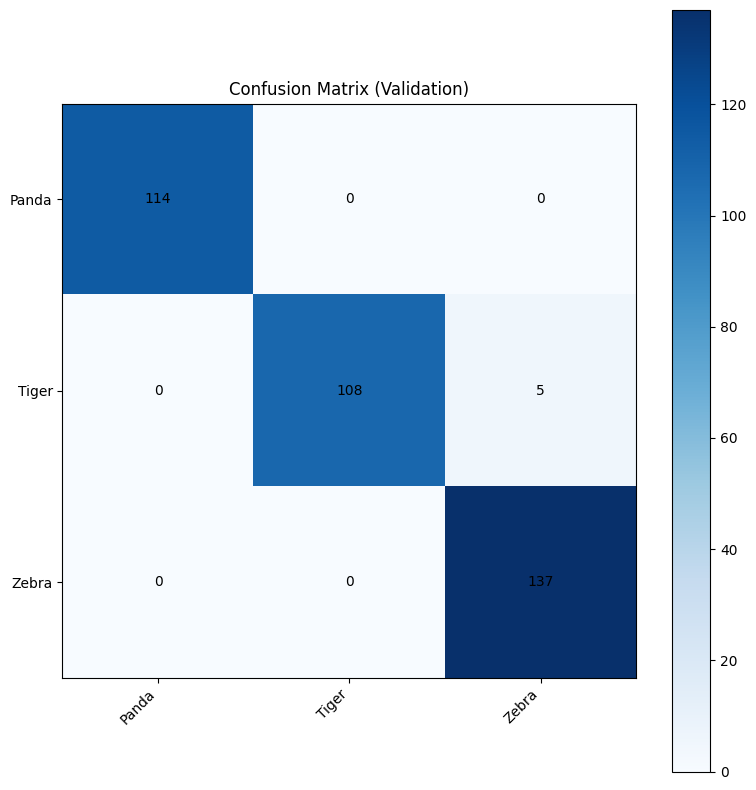

In [7]:
# -------------------------------
# 7. Evaluate (safe version)
# -------------------------------
val_images, val_labels = [], []
for x, y in val_ds.unbatch():
    val_images.append(x.numpy())
    val_labels.append(y.numpy())
val_images = np.array(val_images)
val_labels = np.array(val_labels)

y_prob = model.predict(val_images, verbose=0)
y_pred = y_prob.argmax(axis=1)

# Unique labels actually present
unique_labels = np.unique(val_labels)

print("\nClassification Report:\n")
print(classification_report(
    val_labels,
    y_pred,
    labels=unique_labels,
    target_names=[class_names[i] for i in unique_labels]
))

cm = confusion_matrix(val_labels, y_pred, labels=unique_labels)

plt.figure(figsize=(8,8))
plt.imshow(cm, cmap="Blues")
plt.xticks(range(len(unique_labels)), [class_names[i] for i in unique_labels], rotation=45, ha="right")
plt.yticks(range(len(unique_labels)), [class_names[i] for i in unique_labels])
plt.title("Confusion Matrix (Validation)")
plt.colorbar()
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, int(cm[i, j]), ha="center", va="center")
plt.tight_layout()
plt.show()



8.PREDICT ON SINGLE IMAGE

In [8]:
def predict_image(path):
    img = Image.open(path).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
    arr = np.expand_dims(np.array(img), 0).astype("float32")
    # ❌ Do NOT divide by 255.0
    arr = keras.applications.mobilenet_v2.preprocess_input(arr)

    probs = model.predict(arr, verbose=0)[0]
    idx = probs.argmax()
    print(f"Predicted: {class_names[idx]}  (confidence: {probs[idx]:.3f})")
    plt.imshow(img); plt.axis("off"); plt.show()


# Example:
# predict_image("data/dataset/Panda/your_image.jpg")


Predicted: Panda  (confidence: 0.998)


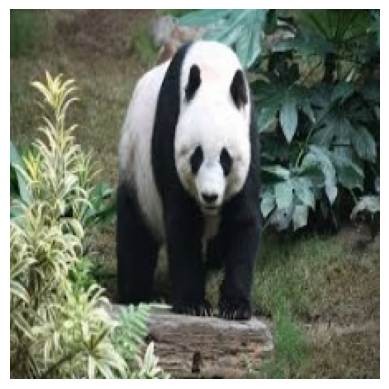

In [ ]:
# Example: pick any image from your dataset
predict_image("data/dataset/Panda/Panda_1.jpeg")




Testing on: data/dataset/Dog/Dog_8_3.jpg
Predicted: Dog  (confidence: 0.994)


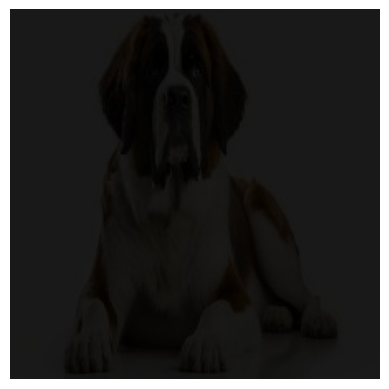

Testing on: data/dataset/Deer/Deer_24_3.jpg
Predicted: Deer  (confidence: 0.928)


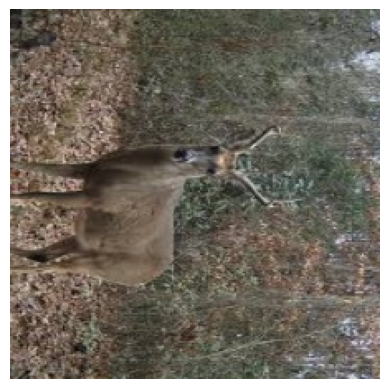

In [10]:
import random, glob

# Pick a random Dog image
random_dog = random.choice(glob.glob("data/dataset/Dog/*"))
print("Testing on:", random_dog)
predict_image(random_dog)

# Pick a random image from ANY class
random_img = random.choice(glob.glob("data/dataset/*/*"))
print("Testing on:", random_img)
predict_image(random_img)

